# Tomato Disease Classification

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, mixed_precision
import matplotlib.pyplot as plt

## Data Collection and Preprocessing

First lets load all the image files from our directory to a tensorflow dataset. (all the images are 256x256)

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 # RGB Channels
EPOCHS = 50

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/plantvillage/PlantVillage_dataset/",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

501

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[6 9 0 2 3 4 0 0 6 4 0 6 2 4 3 0 8 7 7 2 1 7 4 7 4 3 5 7 0 9 7 9]


Lets try to visualize the images

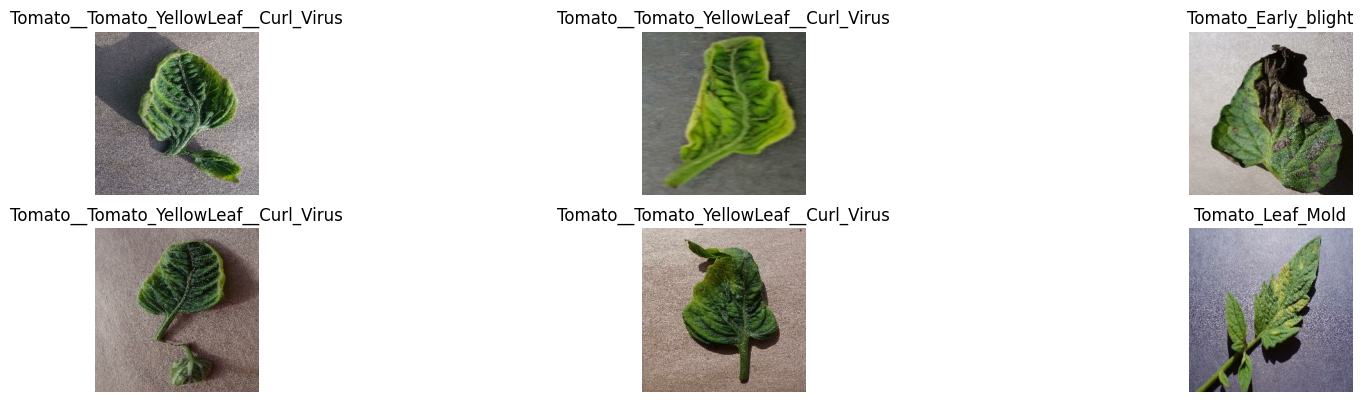

In [7]:
plt.figure(figsize = (20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        
        img = image_batch[0].numpy().astype('uint8') # taking sample image
        
        ax = plt.subplot(8,3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        index = labels_batch[i]
        plt.title(class_names[index])
        plt.axis('OFF')

## test-train-split

80% ==> Training \
20% ==> 10% Validation, 10% Test

In [8]:
train_size = 0.8
len(dataset)*train_size

400.8

So we need 400 batches in training set and rest for testing and validation

In [9]:
train_ds = dataset.take(400)
len(train_ds)

400

In [10]:
temp_ds = dataset.skip(400)
len(temp_ds)

101

In [11]:
val_size = 0.1
len(dataset)*val_size

50.1

In [12]:
val_ds = temp_ds.take(50)
len(val_ds)

50

In [13]:
test_ds = temp_ds.skip(50)
len(test_ds)

51

Now lets make a function to do the above steps of train-test-split

In [14]:
def get_tf_dataset_partitions(ds, train_split, val_split, test_split, shuffle=False, shuffle_size=10000):
    assert abs(train_split + val_split + test_split - 1) < 1e-9
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_tf_dataset_partitions(dataset, 0.72, 0.18, 0.1)

In [16]:
print(len(train_ds), len(val_ds), len(test_ds))

360 90 51


## Cache, Shuffle, and Prefetch the Dataset

In [17]:
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

We are reshaping each image even though all training sample are 256, 256 so that when we give an img to predict which is not of this size, it will work.\
We divide by 255 for scaling as RGB values range from 0 to 255

### Data Augmentation
First we will make the data augmentation layers and then apply them to our training dataset.

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [20]:
# # testing data augmentation
# imgs = [img, data_augmentation(img).numpy().astype('uint8')]
# titles = ['Original', 'Augmented']
# for i in range(2):
#     plt.subplot(1, 2, i + 1)
#     plt.imshow(imgs[i])
#     plt.title(titles[i])
#     plt.axis('off')

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
mixed_precision.set_global_policy('mixed_float16')

In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape = input_shape), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(), 
    layers.Dense(units=64, activation='relu'), 
    layers.Dense(units=n_classes, activation='softmax', dtype='float32')
])

In [32]:
model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,346 (1.06 MB)

 Trainable params: 278,346 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
    )

In [35]:
# fitting model
history = model.fit( 
    train_ds, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=val_ds, 
    verbose=1
)

Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.2791 - loss: 1.9545 - val_accuracy: 0.5639 - val_loss: 1.1959
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6256 - loss: 1.0370 - val_accuracy: 0.5903 - val_loss: 1.1801
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.7669 - loss: 0.6463 - val_accuracy: 0.8108 - val_loss: 0.5387
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8343 - loss: 0.4708 - val_accuracy: 0.7510 - val_loss: 0.8515
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8638 - loss: 0.3900 - val_accuracy: 0.7764 - val_loss: 0.7175
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8858 - loss: 0.3171 - val_accuracy: 0.7931 - val_loss: 0.6948
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8926 - loss: 0.3048 - val_accuracy: 0.8622 - val_loss: 0.4456
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9219 - loss: 0.2195 - 

In [39]:
scores = model.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9106 - loss: 0.6861


In [40]:
scores

[0.6231048703193665, 0.9143389463424683]

## Plotting the Accuracy and Loss Curves

In [41]:
history

In [42]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 360}

In [43]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [44]:
type(history.history['loss'])

list

In [45]:
len(history.history['loss'])

50

In [46]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.6828036308288574,
 0.8999835252761841,
 0.611167848110199,
 0.4716366231441498,
 0.3937329649925232]

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

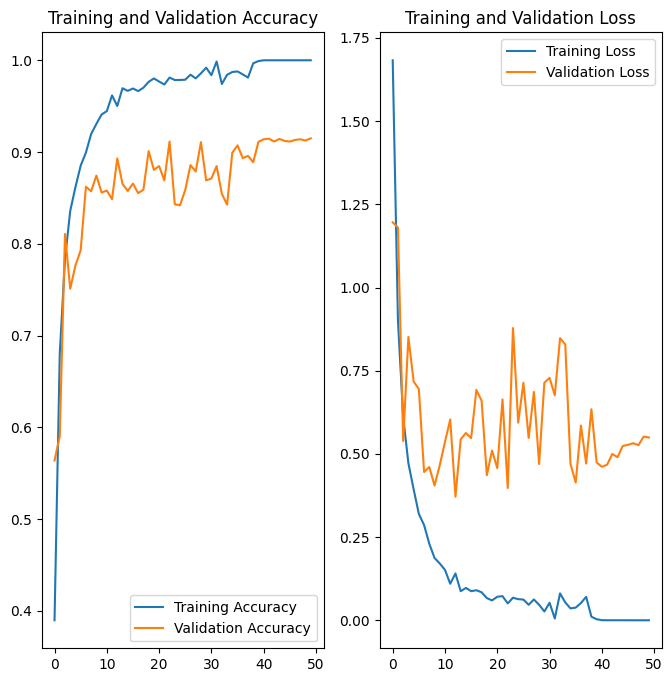

In [48]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label: Tomato_Spider_mites_Two_spotted_spider_mite
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicted label: Tomato_Spider_mites_Two_spotted_spider_mite


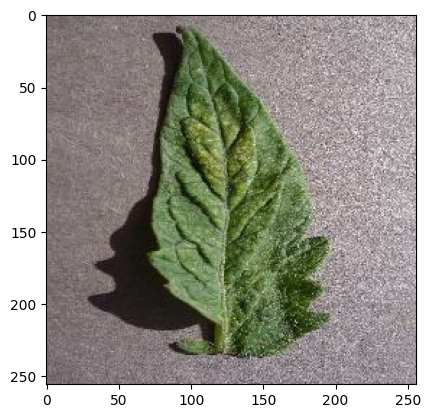

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

In [64]:
# plt.figure(figsize=(25, 25))
# for images, labels in test_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
        
#         predicted_class, confidence = predict(model, images[i].numpy())
#         actual_class = class_names[labels[i]] 
        
#         plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
#         plt.axis("off")

In [57]:
lbls_true = []
lbls_pred = [] # predicted integer labels
pred_confs = [] # confidences

for i in range(len(test_ds)):
    for imgs, lbls in test_ds.take(i + 1):
        lbls_true.extend(lbls.numpy().tolist())

        pred_imgs = model.predict(imgs)
        for pred_img in pred_imgs:
            lbls_pred.append(np.argmax(pred_img))
            pred_confs.append(np.max(pred_img))
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

In [58]:
# changing integer labels to class names
lbls_true_names = list(map(lambda x: class_names[x], lbls_true))
lbls_pred_names = list(map(lambda x: class_names[x], lbls_pred))

In [59]:
# getting confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(lbls_true_names, lbls_pred_names, labels=class_names)
cf_matrix_title = 'Confusion Matrix using Test Set'
print(cf_matrix_title)
print(cf_matrix)

Confusion Matrix using Test Set
[[203   7   1   0   2   0   1   3   0   0]
 [  5  91   8   0   4   0   0   0   0   0]
 [  1   6 177   3   6   1   1   0   0   0]
 [  0   1   2  75  15   2   0   2   0   1]
 [  0   5   2   5 137   0   6   0   1   8]
 [  0   0   0   0   0 174   9   0   0   2]
 [  0   0   0   0   0  13 116   1   0  18]
 [  1   0   2   0   0   1   2 266   0   0]
 [  0   0   0   0   0   0   0   0  30   0]
 [  0   0   1   0   0   0   0   0   0 151]]


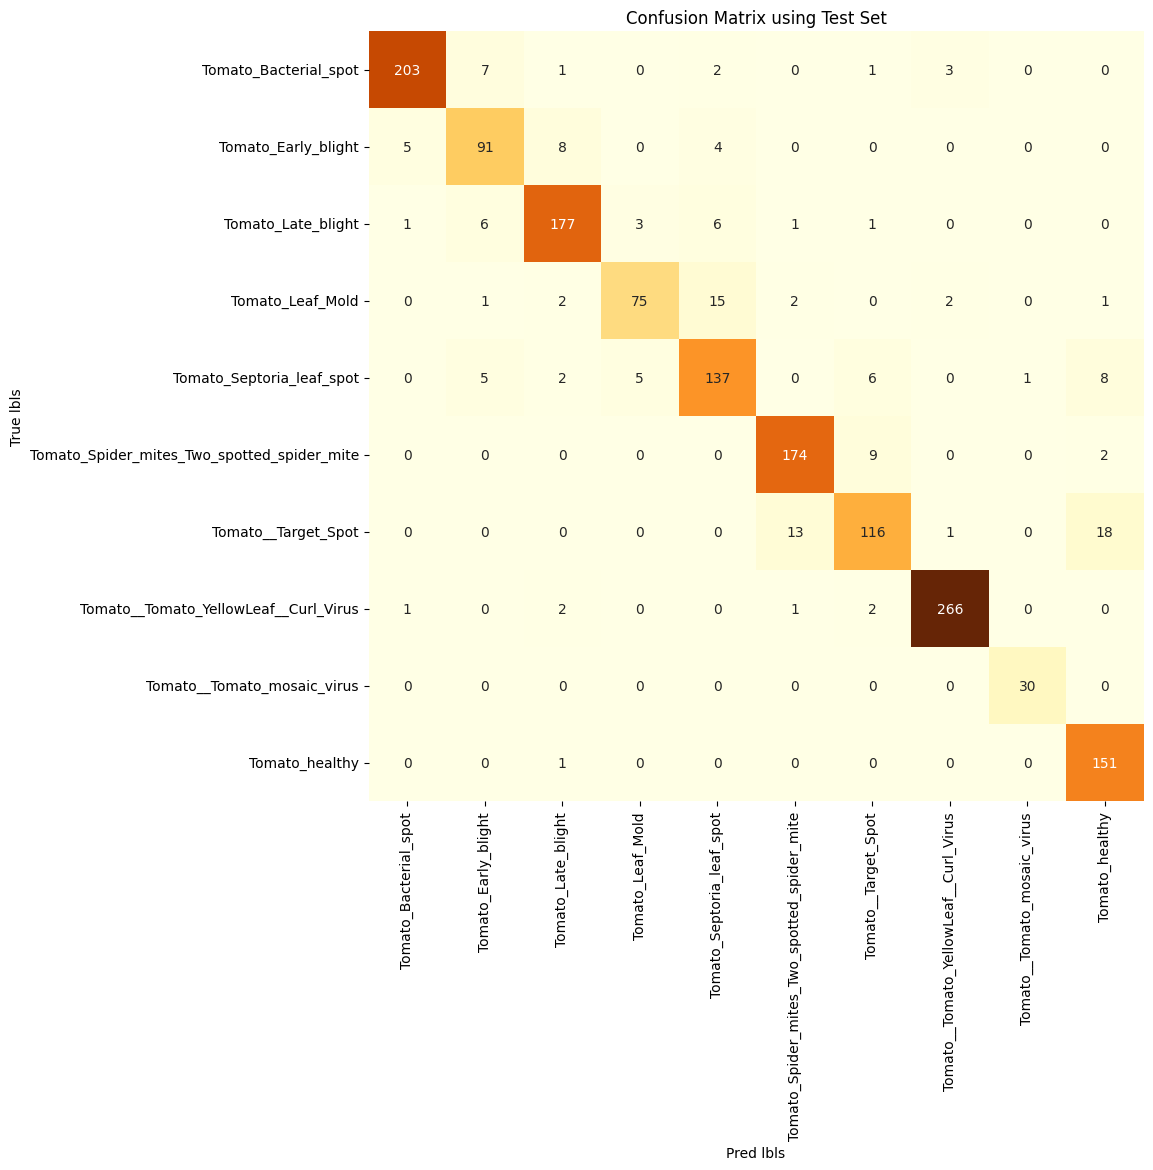

In [60]:
import seaborn as sns
# plotting confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, fmt='g', 
            xticklabels=class_names, yticklabels=class_names, 
            cbar=False, cmap='YlOrBr')
plt.xlabel('Pred lbls')
plt.ylabel('True lbls')
plt.title(cf_matrix_title)
plt.show()

In [61]:
# getting precisions
pred_sums = np.sum(cf_matrix, axis=0)
prec_matrix = cf_matrix / pred_sums
precs = prec_matrix.diagonal()

# getting recalls
true_sums = np.sum(cf_matrix, axis=1)
recall_matrix = cf_matrix / true_sums
recalls = recall_matrix.diagonal()

# getting f1 measures
f1s = (2 * precs * recalls) / (precs + recalls)

In [62]:
# displaying testing set counts
from tabulate import tabulate
counts_tbl = []
for i in range(len(class_names)):
    counts_tbl.append([class_names[i], true_sums[i]])
counts_tbl.append(['Test set', sum(true_sums)])

print('Test set counts:')
print(tabulate(counts_tbl, tablefmt='grid'))

Test set counts:
+---------------------------------------------+------+
| Tomato_Bacterial_spot                       |  217 |
+---------------------------------------------+------+
| Tomato_Early_blight                         |  108 |
+---------------------------------------------+------+
| Tomato_Late_blight                          |  195 |
+---------------------------------------------+------+
| Tomato_Leaf_Mold                            |   98 |
+---------------------------------------------+------+
| Tomato_Septoria_leaf_spot                   |  164 |
+---------------------------------------------+------+
| Tomato_Spider_mites_Two_spotted_spider_mite |  185 |
+---------------------------------------------+------+
| Tomato__Target_Spot                         |  148 |
+---------------------------------------------+------+
| Tomato__Tomato_YellowLeaf__Curl_Virus       |  272 |
+---------------------------------------------+------+
| Tomato__Tomato_mosaic_virus                 | 

In [63]:
import pandas as pd
# displaying evaluations
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s}, 
                        index=class_names)
pd.options.display.float_format = '{:.2%}'.format
evals_df

,Precision,Recall,F1
Tomato_Bacterial_spot,96.67%,93.55%,95.08%
Tomato_Early_blight,82.73%,84.26%,83.49%
Tomato_Late_blight,91.71%,90.77%,91.24%
Tomato_Leaf_Mold,90.36%,76.53%,82.87%
Tomato_Septoria_leaf_spot,83.54%,83.54%,83.54%
Tomato_Spider_mites_Two_spotted_spider_mite,91.10%,94.05%,92.55%
Tomato__Target_Spot,85.93%,78.38%,81.98%
Tomato__Tomato_YellowLeaf__Curl_Virus,97.79%,97.79%,97.79%
Tomato__Tomato_mosaic_virus,96.77%,100.00%,98.36%
Tomato_healthy,83.89%,99.34%,90.96%


## Saving the Model

We append the model to the list of models as a new version

In [ ]:
this_model.save("tomatoes_disease_prediction.h5")

In [ ]:
from IPython.display import FileLink

FileLink(r'tomatoes_disease_prediction.h5')